# JSTOR data parser

In [1]:
import pandas as pd

In [2]:
import matplotlib.pyplot as plt

In [3]:
from collections import Counter

In [4]:
from tqdm.auto import tqdm

In [5]:
from pandas.api.types import is_list_like

In [6]:
from itertools import combinations

In [7]:
import ast

## Explore file with unix tools

In [10]:
!ls ..

Distribution of Papers per Years.png
Distribution of Years since 1900.png
Distribution of Years.png
IMG_1045.jpeg
IMG_1046.jpeg
JSTOR database analyser RESERVE COPY 2025-11-16.ipynb
Review
Silber-Varod&Geri_to appear in OJAKM2025.docx
content_types.png
discipline_cooc.csv
discipline_cooccurrence_1949_to_present_sorted.xlsx
discipline_cooccurrence_ge1000.csv
disciplines_co-occurrence_without_weaker_ones.png
disciplines_co-occurrence_without_weaker_ones.png.zip
disciplines_co-occurrence_without_weaker_ones_marked.png
disciplines_cooc1000.gephi
disciplines_frequencies_main.xlsx
disciplines_frequencies_post_1949.xlsx
discripline_cooccurrences_100k_sample.xlsx
edges_sample.csv
jstor_analysis_code
jstor_metadata_2025-07-30.jsonl
jstor_metadata_2025-07-30.jsonl.gz
jstor_sample_item.json
languages_frequencies_main.xlsx
lineplot.png
lineplot_dataset_manuscript.png
sample.csv
sample_item.json
sample_top_5.csv
top_30_disciplines.png
top_30_langs.png
top_50_disciplines.png
top_50_langs.png
top_85_

In [11]:
!head -n 1 ../jstor_metadata_2025-07-30.jsonl

{"item_id":"81e94608-c4dc-3e28-b08e-7efc0f19553c","review_required":false,"ithaka_doi":"10.2307/community.37317744","identifiers":{"print_isbn":null,"online_isbn":null,"print_issn":null,"online_issn":null,"ssid":"37317744","catsid":null,"journal_code":null,"aluka_doi":null},"title":null,"is_part_of":null,"creators_string":null,"creators":null,"publishers":null,"published_date":null,"languages":null,"discipline_names":null,"issue_number":null,"issue_volume":null,"c5_data_type":"Other","c5_section_type":"Other","content_type":"contributed_content","content_subtype":"contributed_content_documents","ccda_resource_type":"Documents","ccda_resource_subtype":"Oral Histories","collections":["Student Activism"],"contributed_content":true,"licensing_status":"Creative Commons: Attribution-NonCommercial-NoDerivs","url":"www.jstor.org/stable/10.2307/community.37317744"}


## Load into a pandas dataframe (chunks)

In [ ]:
# Initialize empty list to collect smaller DataFrames
# chunks = []

In [13]:
# DISCARDED FOR A MORE OPTIMAL APPROACH:
# Process the file line by line in chunks of 100,000 rows
#with pd.read_json("jstor_metadata_2025-07-30.jsonl", lines=True, chunksize=100_000) as reader:
#    for chunk in reader:
        # Optional: filter or process chunk here
#        chunks.append(chunk)

In [8]:
use_cols = ["title", "languages", "discipline_names", "content_type", "published_date"]
dfs = []
for chunk in tqdm(pd.read_json("../jstor_metadata_2025-07-30.jsonl", lines=True, chunksize=100_000)):
    sub = chunk[use_cols]                                # drop other columns early
    sub = sub[sub["published_date"].notna()]             # drop null dates
    #print(sub['published_date'].str[:4])
    years = sub['published_date'].str[:4].astype(int)  # extract year as int
    sub = sub.assign(year=years)
    sub = sub[sub["year"] > 1949]                        # keep only what you need
    dfs.append(sub.drop(columns=["published_date"]))
df = pd.concat(dfs, ignore_index=True)

0it [00:00, ?it/s]

In [9]:
# Concatenate all chunks into one big DataFrame
#df = pd.concat(chunks, ignore_index=True)
print("DataFrame loaded with shape:", df.shape)
print(df.info())

DataFrame loaded with shape: (10068859, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10068859 entries, 0 to 10068858
Data columns (total 5 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   title             object
 1   languages         object
 2   discipline_names  object
 3   content_type      object
 4   year              int64 
dtypes: int64(1), object(4)
memory usage: 384.1+ MB
None


In [10]:
#df['title'] = df['title'].astype(str)

In [11]:
df.head()

,title,languages,discipline_names,content_type,year
0,APPENDIX D – TABLE 3,[eng],None,multi_part_research_report_part,2011
1,APPENDIX F – TABLE 5,[eng],None,multi_part_research_report_part,2011
2,APPENDIX I - CHART 2,[eng],None,multi_part_research_report_part,2011
3,APPENDIX K – CHART 4,[eng],None,multi_part_research_report_part,2011
4,APPENDIX N – CHART 7,[eng],None,multi_part_research_report_part,2011


## One-percent sample

In [ ]:
#sample_df = pd.read_csv('sample.csv')

In [23]:
sample_df = df.sample(frac=0.01, random_state=42)

In [24]:
sample_df.to_csv('sample_lim_cols.csv')

In [25]:
sample_df.shape

(100689, 5)

In [26]:
sample_df.head()

,title,languages,discipline_names,content_type,year
101827,The Geneva Connection: Jean Servin's Settings ...,[eng],[Music],article,2009
4802733,The Construction of Jacobi and Periodic Jacobi...,[eng],"[Mathematics, Computer Science]",article,1980
6839242,Cold Pumpability Characteristics of Engine Oil...,[eng],"[Engineering, Sustainability]",article,1974
5180172,TÖNE,[ger],[Music],article,2020
5450003,"""Discovering Some New Race"": Rebecca Harding D...",[eng],[Language & Literature],article,2000


## Lineplots for words

In [12]:
def plot_title_keyword_frequencies(df, substrings):
    
    # Drop rows with missing year or missing title
    df = df.dropna(subset=['year', 'title'])
    
    # Count total number of titles per year
    df['title'] = df['title'].astype(str)
    df['token_count'] = df['title'].apply(lambda x: len(x.split()))
    
    freq_data = {}

    for substring in substrings:
        # Count occurrences of substring (case-insensitive)
        df[substring + '_count'] = df['title'].str.lower().str.count(substring.lower())
        
        # Aggregate per year
        yearly = df.groupby('year').agg({
            substring + '_count': 'sum',
            'token_count': 'sum'
        })
        
        # Calculate relative frequency
        yearly[substring + '_freq'] = yearly[substring + '_count'] / yearly['token_count']
        freq_data[substring] = yearly[substring + '_freq']

    # Combine all frequencies into one DataFrame for plotting
    freq_df = pd.DataFrame(freq_data)

    # Plot
    freq_df.plot(kind='line', figsize=(10, 6))
    plt.title("Relative Frequency of Strings in Title by Year")
    plt.xlabel("Year")
    plt.ylabel("Relative Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'lineplot_{'_'.join(substrings)}.png', dpi=300)
    plt.show()


/var/folders/1f/9yycmpbn4ql_z5685cqb9_8c0000gn/T/ipykernel_8250/543256861.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['title'] = df['title'].astype(str)
/var/folders/1f/9yycmpbn4ql_z5685cqb9_8c0000gn/T/ipykernel_8250/543256861.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['token_count'] = df['title'].apply(lambda x: len(x.split()))
/var/folders/1f/9yycmpbn4ql_z5685cqb9_8c0000gn/T/ipykernel_8250/543256861.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

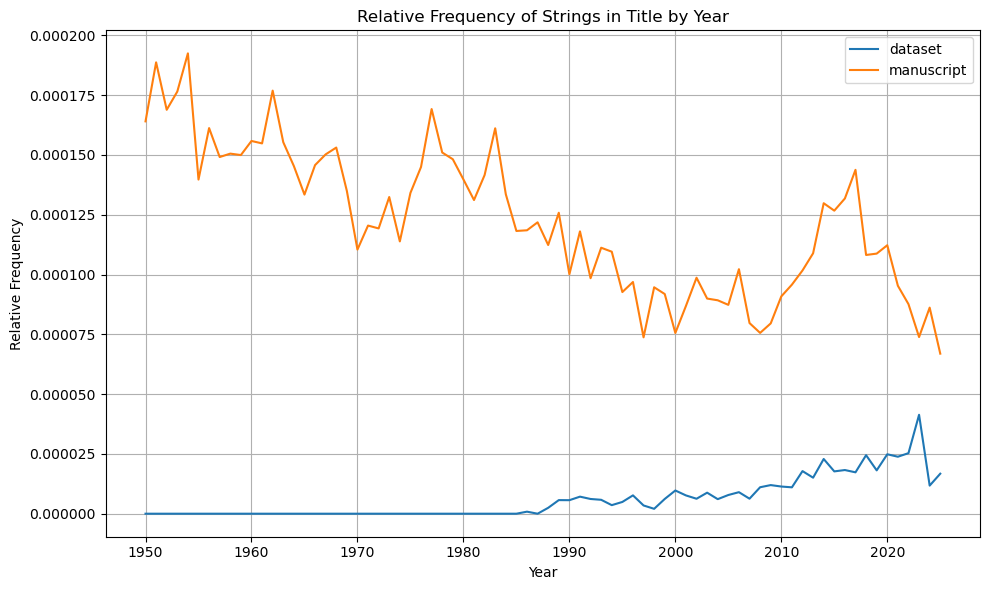

In [13]:
plot_title_keyword_frequencies(df, substrings=['dataset', 'manuscript'])

In [35]:
#plot_title_keyword_frequencies(df_after_1949, substrings=['digital', 'computational'])

In [36]:
#plot_title_keyword_frequencies(df_after_1949, substrings=['database', 'programming', 'computer', 'server'])

In [ ]:
#sample_df.head().to_csv('sample_top_5.csv')

## Year distribution

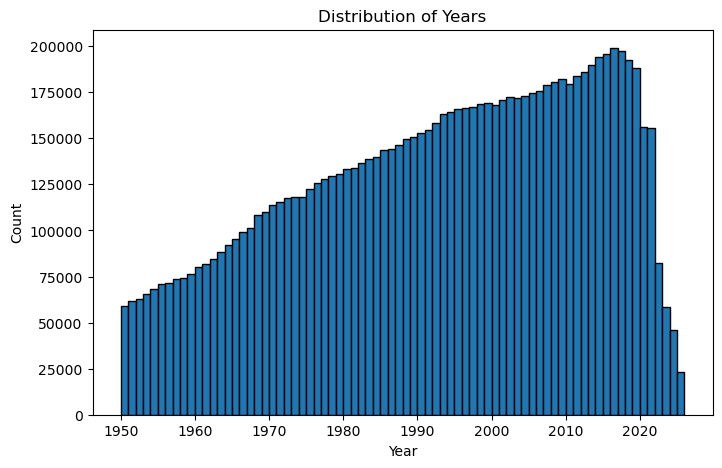

In [41]:
#df_after_1949["year"] = df_after_1949["year"].astype(int)

# Plot histogram
plt.figure(figsize=(8,5))
plt.hist(df["year"], bins=range(df["year"].min(), df["year"].max() + 2), edgecolor="black")
plt.xlabel("Year")
plt.ylabel("Count")
plt.title("Distribution of Years")
plt.show()

## Disciplines

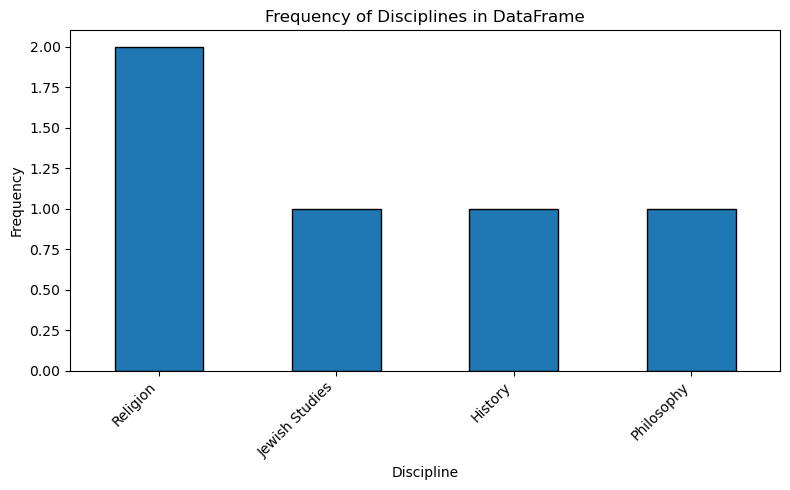

In [14]:
# Example dataframe
example_df = pd.DataFrame({
    "year": [2000, 2001, 2002],
    "discipline_names": [
        ["Religion", "Jewish Studies"],
        ["History"],
        ["Religion", "Philosophy"]
    ]
})

# Explode the lists into separate rows
df_exploded = example_df.explode("discipline_names")

# Count frequencies
discipline_counts = df_exploded["discipline_names"].value_counts()

# Plot
plt.figure(figsize=(8,5))
discipline_counts.plot(kind="bar", edgecolor="black")
plt.xlabel("Discipline")
plt.ylabel("Frequency")
plt.title("Frequency of Disciplines in DataFrame")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

Counting disciplines:   0%|          | 0/10068859 [00:00<?, ?it/s]

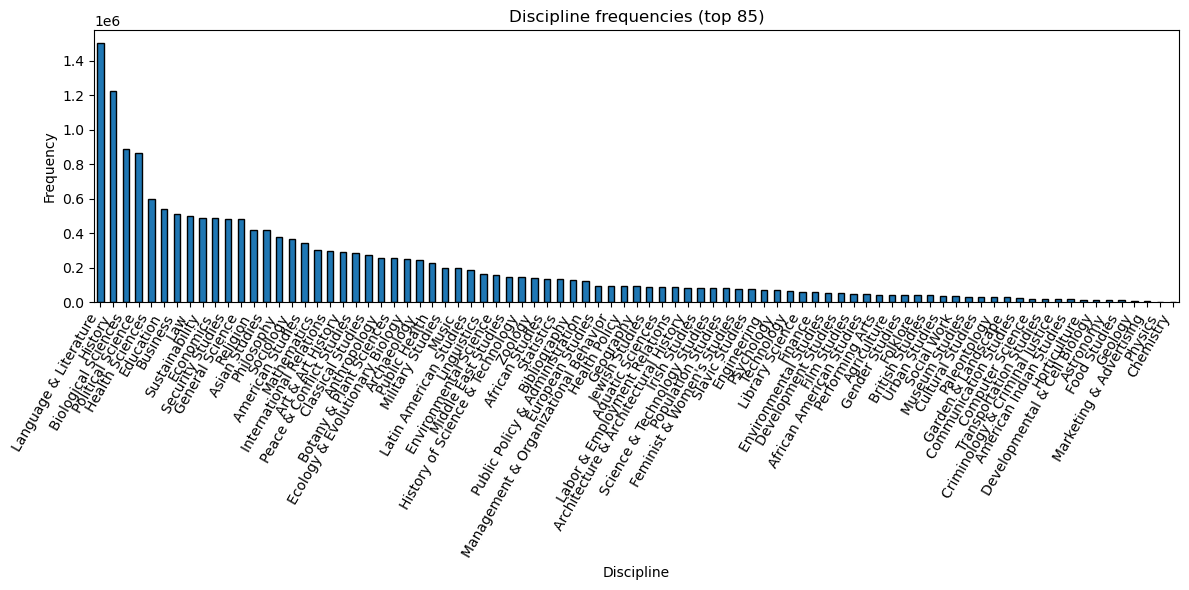

In [15]:
# Assume df exists, with a column 'discipline_names' that holds lists (or NaN)

counts = Counter()

# Iterate with progress bar

for v in tqdm(df["discipline_names"].values, 
              total=len(df), desc="Counting disciplines"):
    # Treat lists/tuples/ndarrays specially (but not strings)
    if is_list_like(v) and not isinstance(v, (str, bytes)):
        # If you want unique per row, use: iterable = set(v)
        iterable = v
        for x in iterable:
            if not pd.isna(x):
                counts[x] += 1
    else:
        # Scalar path
        if not pd.isna(v):
            counts[v] += 1

discipline_counts = pd.Series(counts, dtype="int64").sort_values(ascending=False)

# (Optional) plot top-N
import matplotlib.pyplot as plt
topN = 85
plt.figure(figsize=(12,6))
discipline_counts.head(topN).plot(kind="bar", edgecolor="black")
plt.xlabel("Discipline")
plt.ylabel("Frequency")
plt.title(f"Discipline frequencies (top {topN})")
plt.xticks(rotation=60, ha="right")
plt.tight_layout()
plt.savefig(f'top_{topN}_disciplines.png', dpi=300)
plt.show()

In [16]:
#plt.savefig(f'top_{topN}_disciplines_post_1949.png', dpi=300)

In [17]:
len(counts)

85

In [21]:
counts

Counter({'Sociology': 366179,
         'History': 1222843,
         'Anthropology': 255358,
         'International Relations': 295386,
         'Security Studies': 481512,
         'Archaeology': 242623,
         'Irish Studies': 84199,
         'European Studies': 94537,
         'Transportation Studies': 19631,
         'History of Science & Technology': 144953,
         'American Studies': 345506,
         'Language & Literature': 1502529,
         'Public Policy & Administration': 123908,
         'Gender Studies': 43074,
         'Social Work': 34144,
         'Psychology': 70806,
         'Political Science': 863144,
         'Jewish Studies': 90272,
         'Philosophy': 380639,
         'Religion': 419995,
         'Slavic Studies': 74396,
         'Military Studies': 200438,
         'Linguistics': 164022,
         'Education': 542963,
         'Management & Organizational Behavior': 93953,
         'Law': 501735,
         'Technology': 63874,
         'Communication Studies

In [22]:
counts['Language & Literature']

1502529

In [26]:
discipline_counts.shape

(85,)

In [27]:
#discipline_counts.to_excel('disciplines_frequencies_post_1949.xlsx', header=False)

## Discipline groups comparison (2025-11-16)

In [28]:
# Humanities set
list_hum = [
    "Language & Literature", "History", "Religion", "Philosophy", "Art & Art History",
    "Classical Studies", "Archaeology", "Music", "Film Studies", "Performing Arts",
    "Folklore", "Museum Studies", "Cultural Studies",
]
hum_set = set(list_hum)

In [56]:
def normalize_disciplines(col):
    """Ensure each row is a list (empty list if null/scalar)."""
    def to_list(x):
        if isinstance(x, list):
            return x
        if pd.isna(x):
            return []
        return [x]
    return col.apply(to_list)

def make_subsets(df):
    dn = normalize_disciplines(df["discipline_names"])

    # Subset One: contains "linguistics" anywhere (case-insensitive)
    subset1 = df[dn.apply(lambda xs: any(str(x).lower() == "linguistics" for x in xs))]

    # Subset Two: non-empty and all disciplines within hum_set (no extras)
    subset2 = df[dn.apply(lambda xs: len(xs) > 0 and set(xs).issubset(hum_set))]

    return subset1, subset2

def rel_freq_by_year(df, substring, text_col="title", year_col="year"):
    """Relative frequency of substring per year in the chosen text column."""
    mask = df[text_col].fillna("").str.contains(substring, case=False, regex=True)
    stats = (
        df.assign(match=mask)
          .groupby(year_col, observed=True)
          .agg(total=("match", "size"), matches=("match", "sum"))
          .sort_index()
    )
    stats["rel_freq"] = stats["matches"] / stats["total"]
    return stats["rel_freq"]

In [52]:
def plot_substring_by_subsets(subset1, subset2, substring, text_col="title", year_col="year"):
    freq1 = rel_freq_by_year(subset1, substring, text_col=text_col, year_col=year_col)
    freq2 = rel_freq_by_year(subset2, substring, text_col=text_col, year_col=year_col)

    plt.figure(figsize=(8, 4))
    plt.plot(freq1.index, freq1.values, label="Subset One: has linguistics")
    plt.plot(freq2.index, freq2.values, label="Subset Two: only humanities set")
    plt.xlabel("Year")
    plt.ylabel(f'Relative frequency of "{substring}" in {text_col}')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'pics/disciplines_compared/query_{substring}_all_ling_vs_hum_only.png', dpi=300)
    plt.show()

In [ ]:
subset1, subset2 = make_subsets(df)

In [35]:
subset1.shape, subset2.shape

((164022, 5), (2349034, 5))

In [37]:
subset_ling = subset1
subset_hum_only = subset2

In [38]:
subset2.sample(100)

,title,languages,discipline_names,content_type,year
8770999,Front Matter,[eng],[Philosophy],article,1993
2076864,FINKING,[eng],[Language & Literature],article,1968
5056316,יהדות רוסיה בחורבן ובמרי,[heb],[Language & Literature],article,1963
4597225,LES ORGANISATIONS ET LA LIBERTÉ DE LA RECHERCHE,[fre],[Philosophy],article,1966
9022822,Miniature Scores Received,[eng],[Music],article,1969
...,...,...,...,...,...
9275881,The Buried Lake [Poem],[eng],[Language & Literature],article,1953
4630617,Allen Stewart Konigsberg Becomes Woody Allen: ...,[eng],"[Film Studies, Language & Literature]",article,1991
511209,Front Matter,[fre],[History],article,1982
7805742,Pioneer Study,[eng],[Language & Literature],article,1952


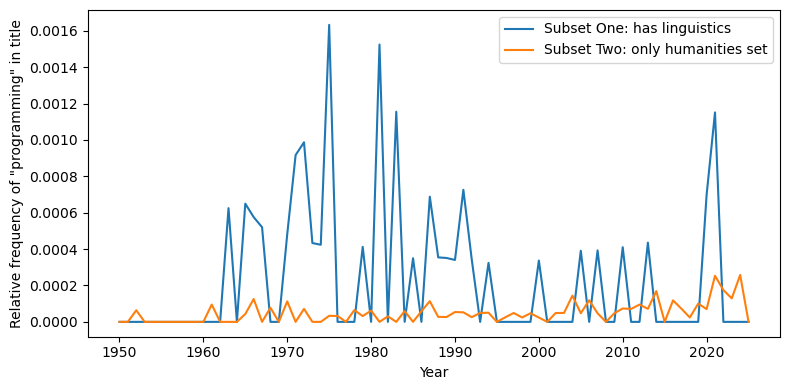

In [57]:
plot_substring_by_subsets(subset1=subset1, subset2=subset2, substring="programming")

In [59]:
list_of_substrings = [
    'programming',
    '\\bAI\\b',
    'Artificial intelligence',
    'Character recognition',
    'ChatGPT',
    'Clustering analysis',
    'Comput.+?\\b',
    'Computational',
    'Digital',
    'Distant reading',
    'Entity Recognition',
    'GenAI',
    'Generative AI',
    'Generative Artificial intelligence',
    'Humanities Computing',
    'Large language model',
    '\\bLLM\\b',
    'Literary Computing',
    'Machine learning',
    'Natural language processing',
    'NLP',
    'NER',
    'Network analysis',
    '\\bOCR\\b',
    'Pattern recognition']

  0%|          | 0/22 [00:00<?, ?it/s]

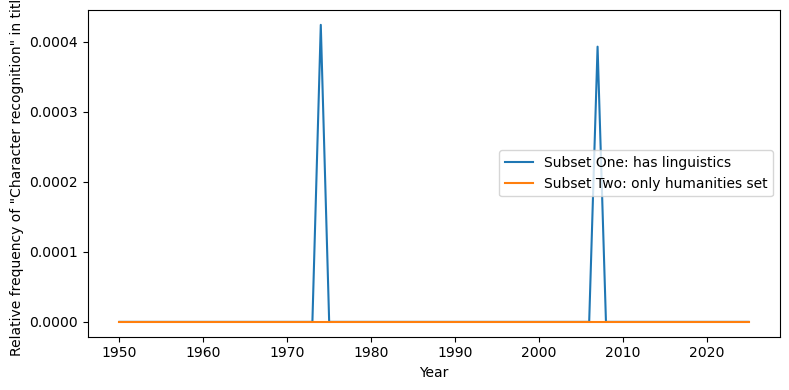

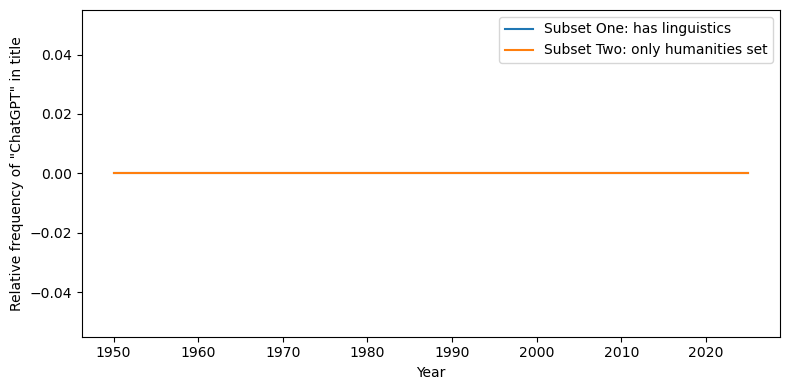

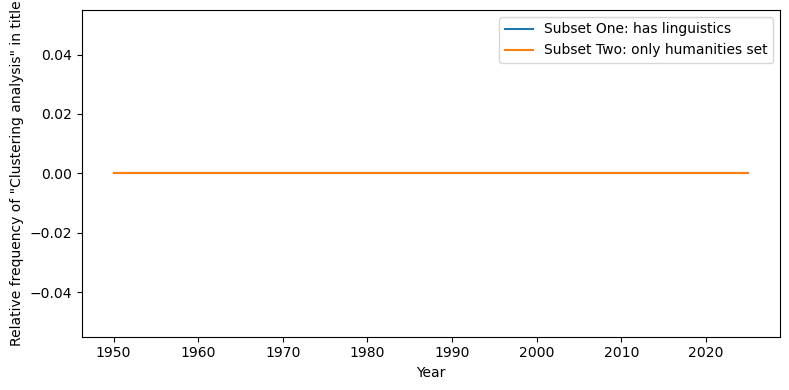

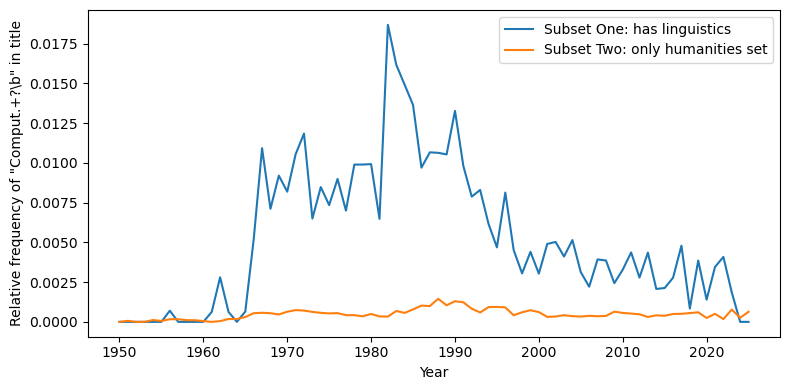

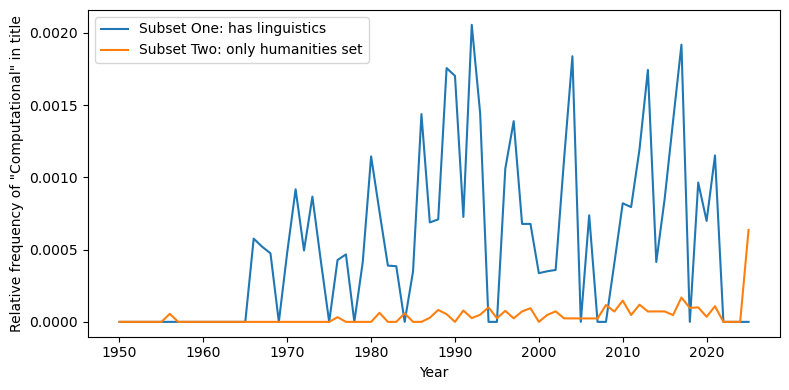

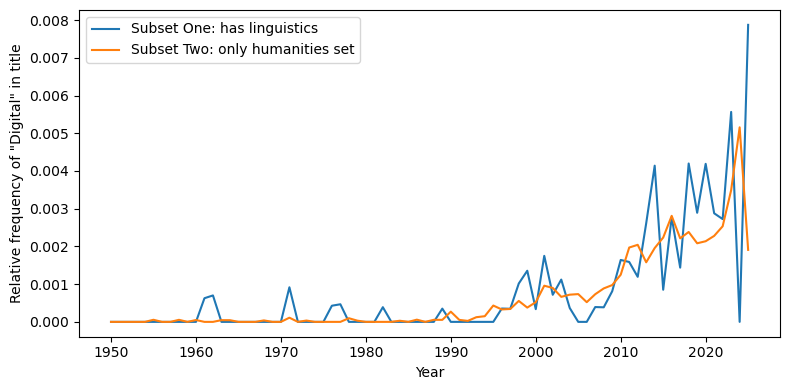

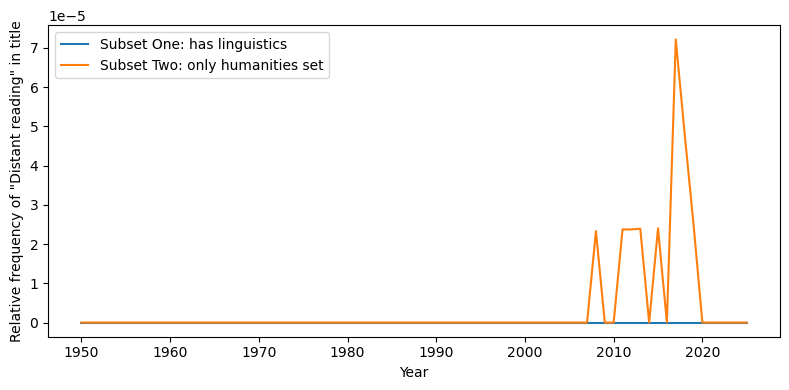

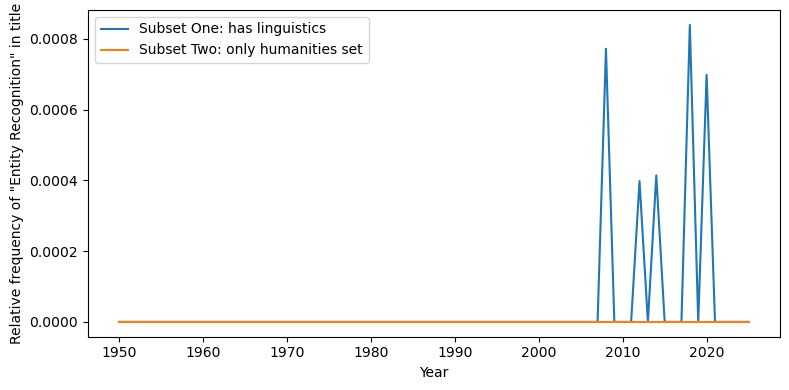

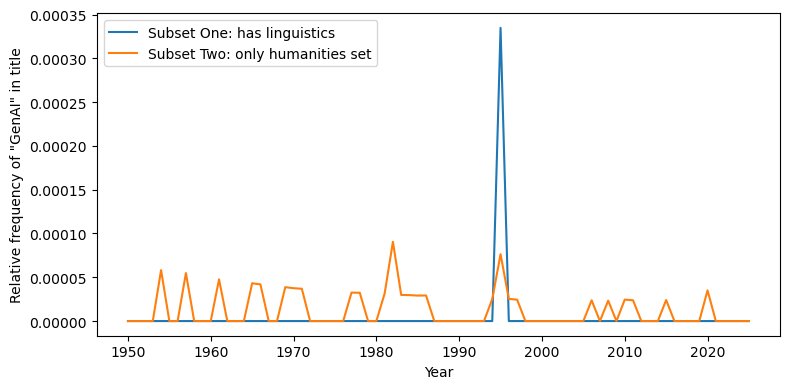

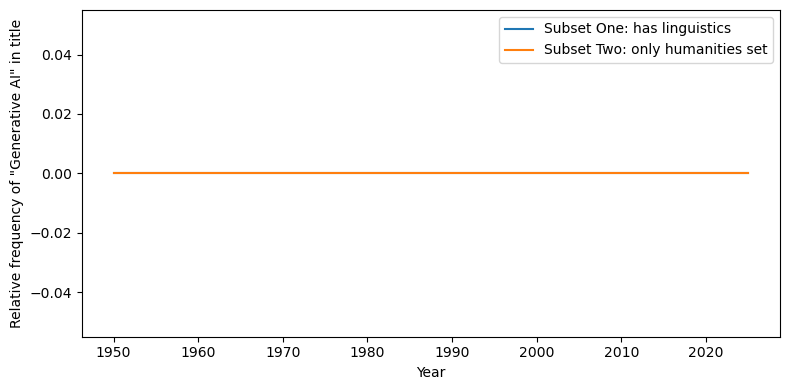

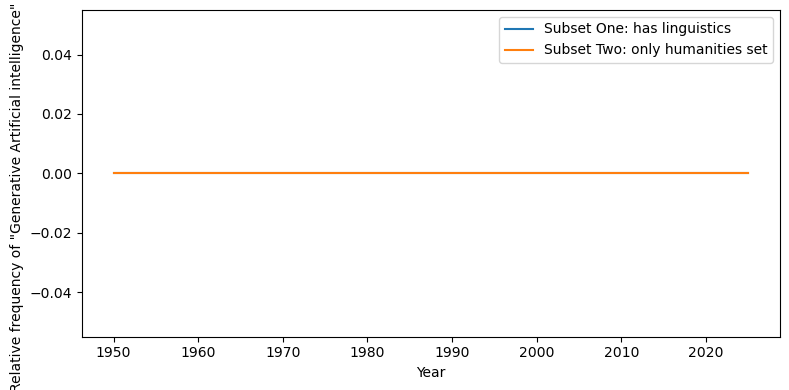

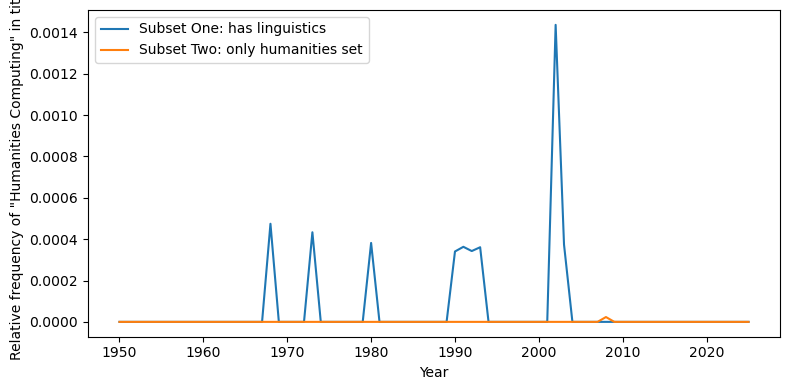

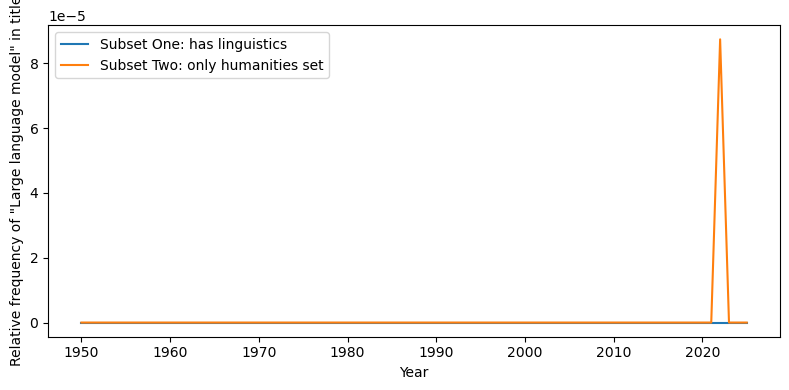

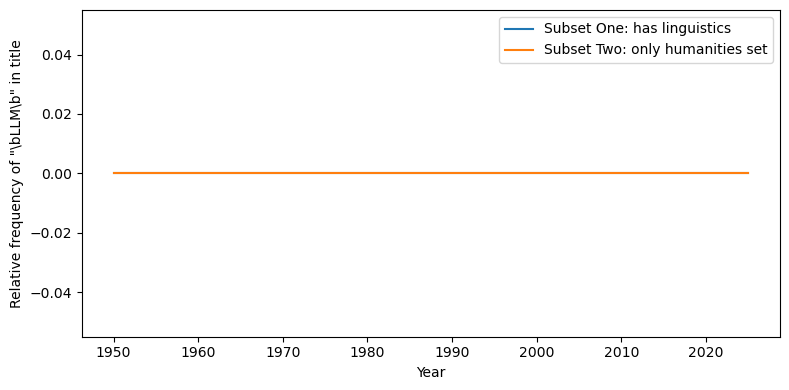

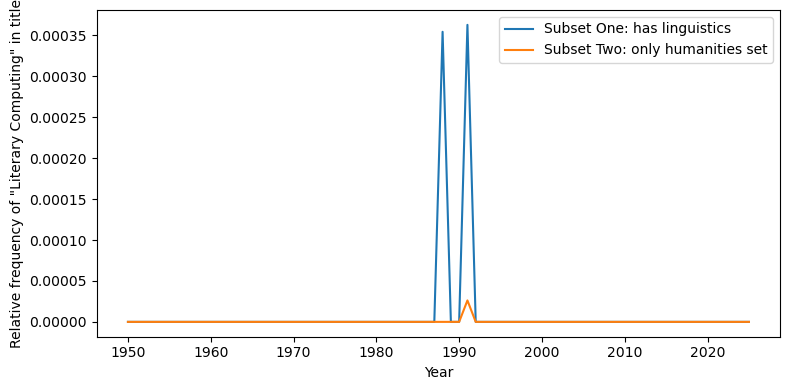

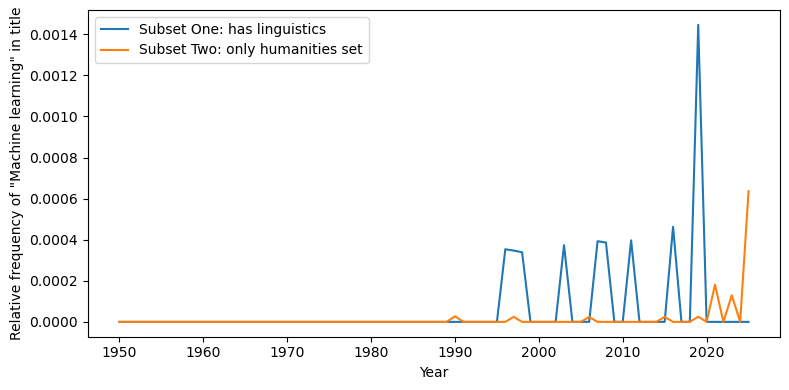

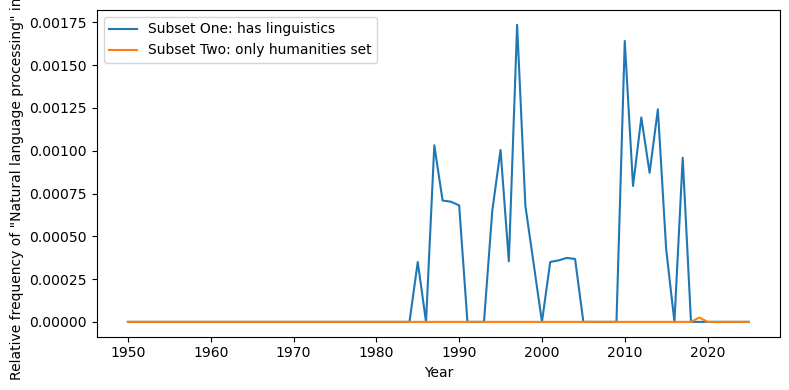

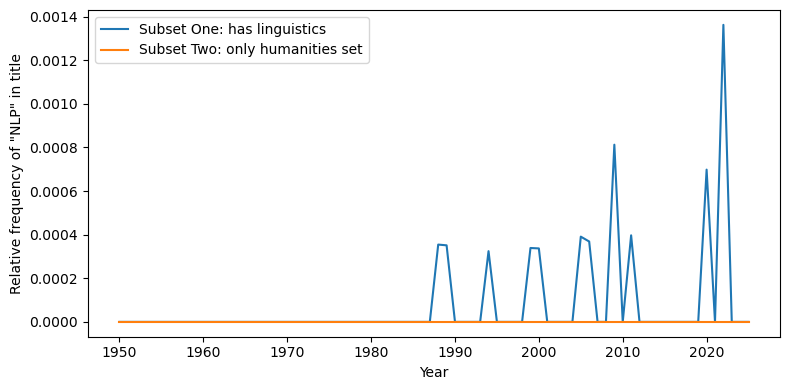

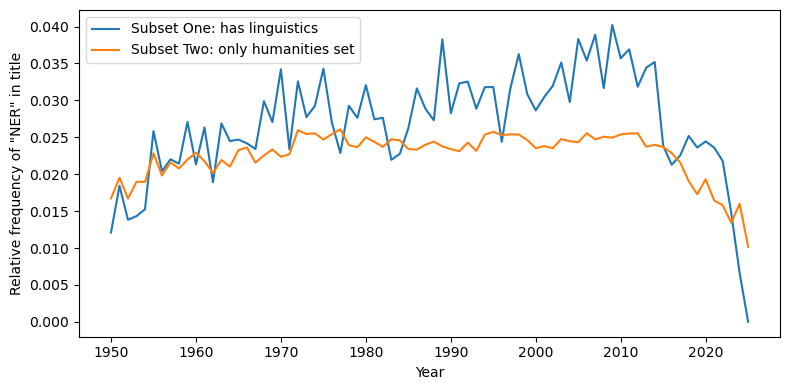

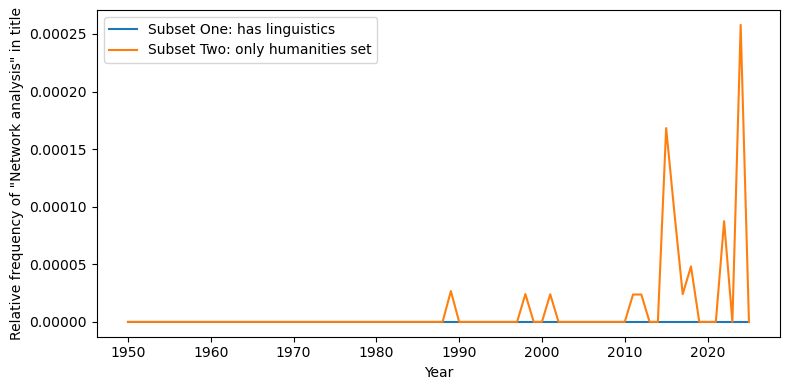

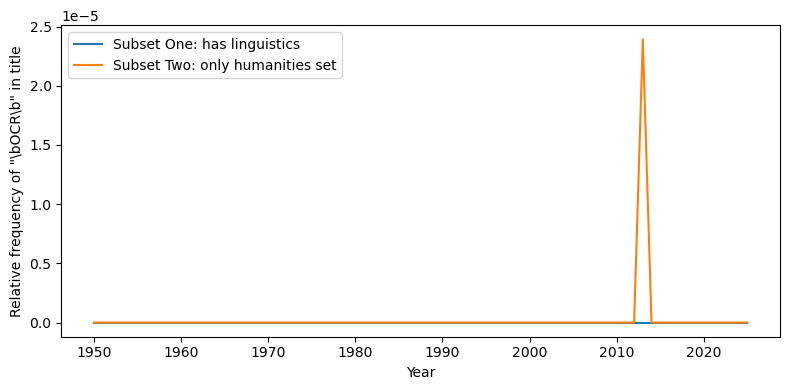

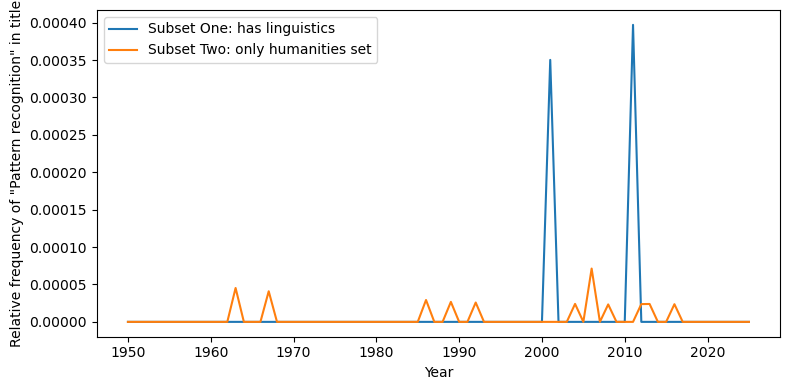

In [61]:
for substring in tqdm(list_of_substrings[3:]):
    plot_substring_by_subsets(subset1=subset_ling, 
                              subset2=subset_hum_only, substring=substring)

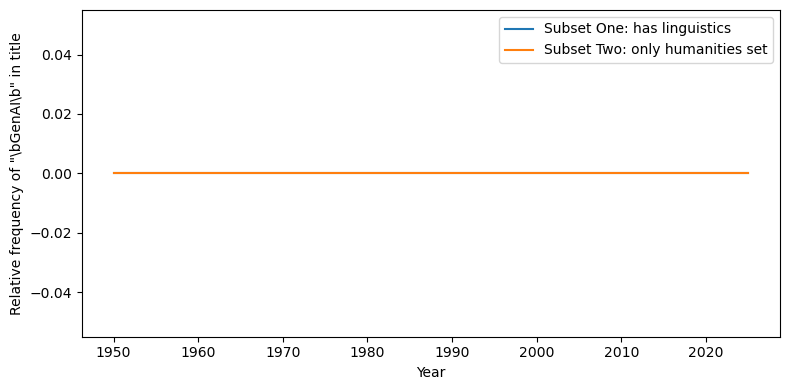

In [66]:
plot_substring_by_subsets(subset1=subset1, subset2=subset2, substring="\\bGenAI\\b")

### Some results verification

In [67]:
def save_titles(df, pattern, outfile, text_col="title", case=False, regex=True):
    """
    pattern: substring or regex (raw string for \b, etc.)
    outfile: path to write the titles (txt, one per line)
    """
    matches = df[text_col].fillna("").str.contains(pattern, case=case, regex=regex, na=False)
    df.loc[matches, text_col].to_csv(outfile, index=False, header=False)

In [69]:
# Examples:
# substring search (case-insensitive)
save_titles(subset_hum_only, "Artificial intelligence", "titles_Artificial_intelligence_humanities.txt", case=False, regex=True)

In [70]:
for substring in tqdm(list_of_substrings):
    save_titles(subset_hum_only, substring, 
                f'data_output/disciplines_compared/titles_humanities_{substring.replace(" ","_")}.txt', 
                case=False, 
                regex=True)

  0%|          | 0/25 [00:00<?, ?it/s]

In [71]:
for substring in tqdm(list_of_substrings):
    save_titles(subset_ling, substring, 
                f'data_output/disciplines_compared/titles_linguistics_{substring.replace(" ","_")}.txt', 
                case=False, 
                regex=True)

  0%|          | 0/25 [00:00<?, ?it/s]

## Languages

In [ ]:
df["languages"][:5]

NameError: name 'df_after_1949' is not defined

In [ ]:
# Assume df exists, with a column 'discipline_names' that holds lists (or NaN)

lang_counts = Counter()

# Iterate with progress bar

for v in tqdm(df["languages"].values, 
              total=len(df)):
    # Treat lists/tuples/ndarrays specially (but not strings)
    if is_list_like(v) and not isinstance(v, (str, bytes)):
        # If you want unique per row, use: iterable = set(v)
        iterable = v
        for x in iterable:
            if not pd.isna(x):
                lang_counts[x] += 1
    else:
        # Scalar path
        if not pd.isna(v):
            lang_counts[v] += 1

lang_counts = pd.Series(lang_counts, dtype="int64").sort_values(ascending=False)


In [ ]:
lang_counts

In [ ]:

# (Optional) plot top-N
import matplotlib.pyplot as plt
topN = 50
plt.figure(figsize=(12,6))
lang_counts.head(topN).plot(kind="bar", edgecolor="black")
plt.xlabel("Discipline")
plt.ylabel("Frequency")
plt.title(f"Discipline frequencies (top {topN})")
plt.xticks(rotation=60, ha="right")
plt.tight_layout()
plt.savefig(f'top_{topN}_langs_post1949.png', dpi=300)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
topN = 30
plt.figure(figsize=(12,6))
lang_counts.head(topN).plot(kind="bar", edgecolor="black")
plt.xlabel("Language")
plt.ylabel("Frequency")
plt.title(f"Language frequencies (top {topN})")
plt.xticks(rotation=60, ha="right")
plt.tight_layout()
plt.savefig(f'top_{topN}_langs_post1949.png', dpi=300)
plt.show()

In [ ]:
lang_counts[:10]

In [ ]:
lang_counts[:10] / lang_counts.sum()

In [ ]:
6.226694 * (10**-2)

In [ ]:
lang_counts.to_excel('languages_frequencies_post1949.xlsx', header=False)

## Content types

In [ ]:
df_after_1949.columns

In [ ]:
sample_df.info()

In [ ]:
sample_df['content_type'].value_counts()

In [ ]:
# # Count frequencies
content_type_counts = df_after_1949["content_type"].value_counts()

# Plot
plt.figure(figsize=(8,5))
content_type_counts.plot(kind="bar", edgecolor="black")
plt.xlabel("Discipline")
plt.ylabel("Frequency")
plt.title("Frequency of Disciplines in DataFrame")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig('content_types.png')
plt.show()

In [ ]:
content_type_counts 

In [ ]:
content_type_counts / content_type_counts.sum()

# October 2025 work package

* Discipline category: calculate trends; co-occurrences.
* Year category: our study will focus on the years 1949-2024
* Frequencies of disciplines per year and per language. Are disciplines appear also in other languages than Eng?
* Nitza and Vered will create a list of search queries for the titles. Daniil will then review it. For this task, it would be better if we have txt/csv files with list of titles per discipline with indication of year. If possible, also csv per language. Is this possible? 
* DOI: Daniil will remove duplicates and re do the frequency graphs.
* Daniil, Nitza and I looked at our data from last year when we started this research.  Our manual advanced queries in JSTOR showed exactly the same steep decline of publications from 2018 (pick year) and on.

Thank you both
Vered

### DOI deduplication

In [ ]:
#for col in df.columns:
#    df[col] = None
#del df
#gc.collect()

In [57]:
df_after_1949.shape[0]

10123776

In [49]:
df_after_1949['ithaka_doi'].count()

10123776

In [40]:
df_after_1949['ithaka_doi'].nunique()

10123776

In [39]:
def _parse_list(x):
    """Return a Python list from a cell that may be a list or a stringified list."""
    if isinstance(x, list):
        items = x
    elif pd.isna(x):
        return []
    else:
        # Safely parse strings like "['A', 'B']" or '["A","B"]'
        items = ast.literal_eval(str(x))
    # Normalize: strip whitespace, drop empties, dedupe within a row
    cleaned = {str(i).strip() for i in items if str(i).strip()}
    return list(cleaned)

def cooccurrence_from_df(df, col="discipline_names"):
    counter = Counter()
    for items in df[col].map(_parse_list):
        if len(items) >= 2:
            # Sort to enforce undirected canonical order (A,B) with A<=B
            for a, b in combinations(sorted(items), 2):
                counter[(a, b)] += 1

    # Build edge list DataFrame
    edges = pd.DataFrame(
        [(a, b, w) for (a, b), w in counter.items()],
        columns=["Source", "Target", "Weight"]
    ).sort_values(["Source", "Target"], ignore_index=True)

    return edges


In [40]:
edges = cooccurrence_from_df(sample_df)

In [41]:
edges

,Source,Target,Weight
0,African American Studies,African Studies,71
1,African American Studies,American Indian Studies,4
2,African American Studies,American Studies,136
3,African American Studies,Art & Art History,2
4,African American Studies,Asian Studies,7
...,...,...,...
1278,Sustainability,Transportation Studies,23
1279,Sustainability,Urban Studies,182
1280,Sustainability,Zoology,1
1281,Technology,Transportation Studies,6


In [42]:
edges.to_csv('edges_sample.csv')

In [43]:
edges_huge = cooccurrence_from_df(df_after_1949)

In [44]:
edges_huge.to_csv('discipline_cooc.csv', index=False)

In [46]:
edges_df_filtered = edges_huge[edges_huge["Weight"] >= 1000].copy()
edges_df_filtered.to_csv("discipline_cooccurrence_ge1000.csv", index=False)

## Non-chunked crashes for memory shortage

In [ ]:
#df = pd.read_json("jstor_metadata_2025-07-30.jsonl", lines=True)

In [ ]:
#print(df.info())
#print(df.head())